# TODO
- explanations and documentation (mostly done)
- rectangle plot (done)
- upper bound for epsilon (done)
- Transpose? (done)
- second example for fixed_input_y (done)
- fix error in method find_adversarial_example()

# Tutorial: Neural network verification with SMT solver Z3

In this tutorial, you will learn how to verify the adversarial robustness of a neural network with an SMT solver. First, a neural network for classification is implemented. Then, the model is verified using the [theorem prover Z3 from Microsoft Research](https://github.com/Z3Prover/z3).

The Jupyter Notebook can be executed in Google Colab or on a local machine where Python and the packages jupyter, PyTorch, scikit-learn, matplotlib, numpy and tqdm are installed. The notebook can be executed using a CUDA GPU.

Using pip, the z3 solver is downloaded and installed

In [2]:
%pip install z3-solver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54.5 MB 107 kB/s 


To carry out the individual steps, some Python libraries are imported.
First, import Z3.

In [3]:
# for SMT-based verification
from z3 import *

[PyTorch](https://pytorch.org/) is a machine learning framework for Python.

In [4]:
# imports for pytorch
import torch
from torch import nn
from torch.autograd import Variable

In addition, the [scikit-learn](https://scikit-learn.org/stable/) library is used to import the data set.

In [5]:
# imports for sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Some other libraries provide extended functionalities. 

In [6]:
# import for progress bar
import tqdm

# numpy
import numpy as np

# for plots
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# for measuring runtime
import time

## Load data set

Training and test data must be available to train the ML model. The dataset is downloaded, then scaled and split into train and test set using scikit-learn.

In this tutorial the [Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) is used to train the neural network. The data set consists of 3 different species of Iris flowers (Setosa, Versicolour, and Virginica). The input features are the sepal length, the sepal width, the petal length and the petal width.

In [7]:
iris = load_iris()

X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']
  
print(f"Shape of X (data): {X.shape}")
print(f"Shape of y (target): {y.shape} {y.dtype}")
print(f"Example of x and y pair: {X[0]} {y[0]}")

# Scale data to have mean 0 and variance 1 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

print("Shape of training set X", X_train.shape)
print("Shape of test set X", X_test.shape)

Shape of X (data): (150, 4)
Shape of y (target): (150,) int64
Example of x and y pair: [5.1 3.5 1.4 0.2] 0
Shape of training set X (120, 4)
Shape of test set X (30, 4)


## Visualize data set

The following show_plots function is used to plot the input features and their classification. The Rectangle plot is used later for visualizing the robustness.

In [8]:
plt.style.use('ggplot')

def show_plots(X, y, fixed_input = None, epsilon = None, title = ''):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
  fig.suptitle(title, fontsize=16)
  for target, target_name in enumerate(names):
      X_plot = X[y == target]
      ax1.plot(X_plot[:, 0], X_plot[:, 1], 
              linestyle='none', 
              marker='o', 
              label=target_name)
  ax1.set_xlabel(feature_names[0])
  ax1.set_ylabel(feature_names[1])
  ax1.axis('equal')
  ax1.legend()

  for target, target_name in enumerate(names):
      X_plot = X[y == target]
      ax2.plot(X_plot[:, 2], X_plot[:, 3], 
              linestyle='none', 
              marker='o', 
              label=target_name)
  ax2.set_xlabel(feature_names[2])
  ax2.set_ylabel(feature_names[3])
  ax2.axis('equal')
  ax2.legend()

  if fixed_input is not None and epsilon is not None:
    #add rectangle to plot -> shows infinity norm 
    ax1.add_patch(Rectangle((fixed_input[0] - epsilon, fixed_input[1] - epsilon), 
                            2*epsilon, 2*epsilon, 
                            edgecolor='pink',
                            facecolor='none',      
                            lw=4))
    ax1.set_aspect("equal", adjustable="datalim")

    ax2.add_patch(Rectangle((fixed_input[2]-epsilon, fixed_input[3]-epsilon), 
                            2*epsilon, 2*epsilon, 
                            edgecolor='pink',
                            facecolor='none',      
                            lw=4))
    ax2.set_aspect("equal", adjustable="datalim")


The following visualisation of the data set shows the correct classification of the input data.

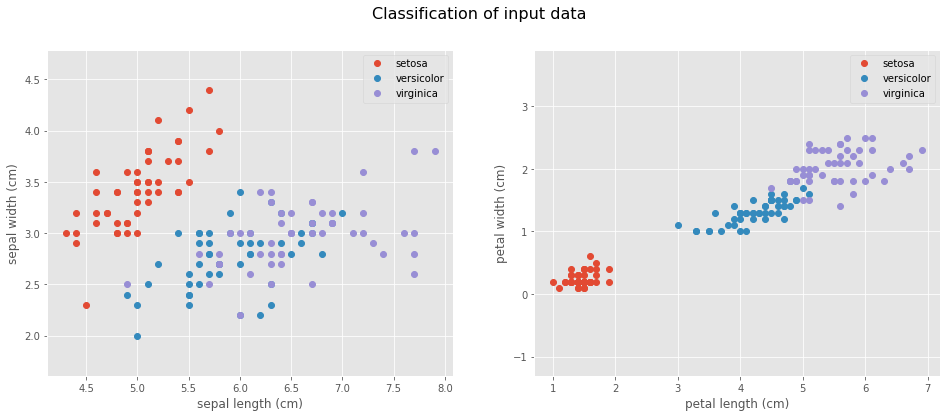

In [9]:
show_plots(X, y, title='Classification of input data')

## Define model

The class NeuralNetwork (inherited of PyTorch´s nn.Module) allows initializing a neural network with different layers.
Here, we use a simple network with only three fully connected layers, because complex networks require high computational effort for verification. As activation function ReLU is used, because ReLU is piecewise linear and therefore easier for SMT based verification.

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

Using cuda device


## Train model

The following function is used to train the neural network using an optimizer and a loss function.

In [11]:
def train(X, y, model, loss_fn, optimizer):
    model.train()
    
    # convert numpy array to pytorch tensor
    X = Variable(torch.from_numpy(X)).float()
    y = Variable(torch.from_numpy(y)).long()
    X = X.to(device)
    y = y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss = loss.item()
    return loss

The predict-function is used to generate the output of the ML model based on the learned weights and biases.

In [12]:
def predict(X, model):
    model.eval()
    with torch.no_grad():
        X = Variable(torch.from_numpy(X)).float()
        X = X.to(device)
        pred = model(X)
        pred = pred.argmax(1)
        pred = pred.cpu().detach().numpy()
    return pred

In the test-function, the output of the ML model for input values is compared with the expected (and correct) classification.

In [13]:
def test(X, y, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        X = Variable(torch.from_numpy(X)).float()
        y = Variable(torch.from_numpy(y)).long()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= X.shape[0]
    return correct, test_loss

The following function is used to train the model over a number of epochs in order to increase the accuracy (on the test data) of the model.
As loss function cross entropy and as optimizer Adam is used.

In [14]:
def train_model(model, epochs):
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


  loss_list     = np.zeros((epochs,))
  accuracy_list = np.zeros((epochs,))

  for epoch in tqdm.trange(epochs):
    loss_list[epoch] = train(X_train, y_train, model, loss_fn, optimizer)
    correct, test_loss = test(X_test, y_test, model, loss_fn)
    accuracy_list[epoch] = correct
  
  print()
  print("Done. Accuracy:", accuracy_list[-1])

For reproducability a manual seed is used. Then, the model is initialized and trained via the defined functions. In this example, a neural network with 20 neurons in each layer is used. The number of epochs is set to 100.

In [15]:
torch.manual_seed(42)

model = NeuralNetwork(input_dim=X_train.shape[1], output_dim=3, number_of_neurons=20).to(device)
print(model)

train_model(model, epochs=100)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)


100%|██████████| 100/100 [00:00<00:00, 164.66it/s]


Done. Accuracy: 0.8666666666666667


The following plots show the expected classification and the classification of the neural network on the dataset

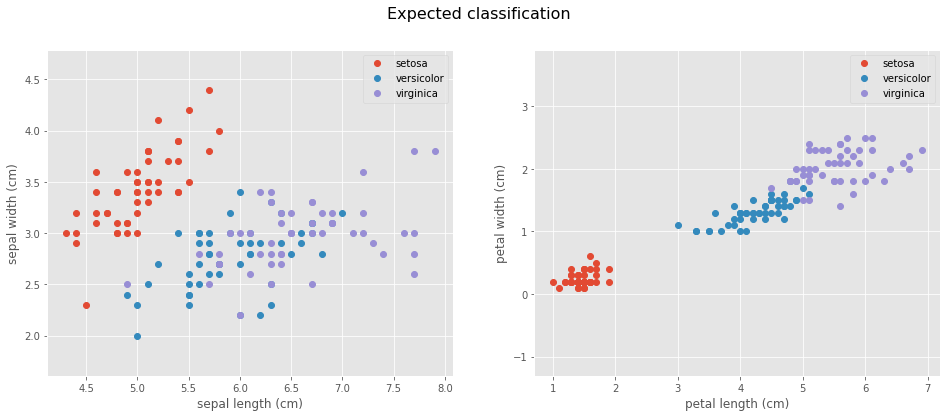

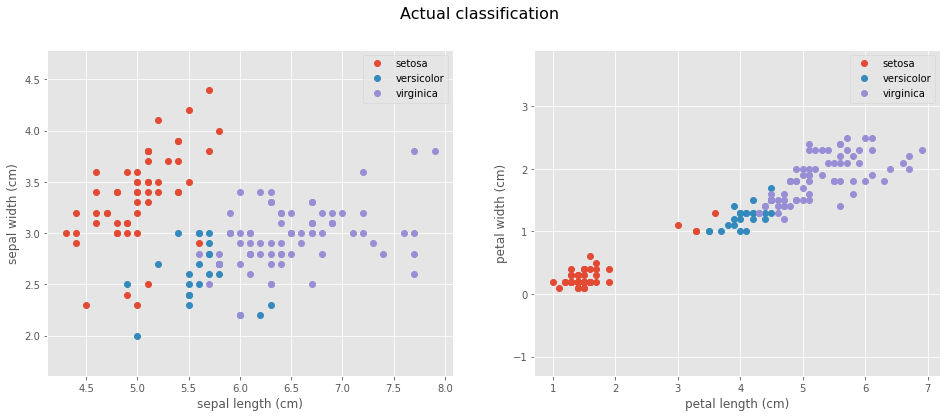

In [16]:
show_plots(X, y, title = 'Expected classification')
show_plots(X, predict(X_scaled, model), title = 'Actual classification')

## Adversarial robustness verification

The next step will be to create a solver with Z3 in order to find Aversarial Examples. "An adversarial example is an instance with small, intentional feature perturbations that cause a machine learning model to make a false prediction." (For more information on adversarial examples see [this article](https://christophm.github.io/interpretable-ml-book/adversarial.html).

The ML model was trained on the iris dataset in the previous section.
Now the task is to recreate the model using the trained weights and the layers of the model. To do this, the learned weights and biases must first be extracted from the model. This is done by iterating over the layers and saving the weights and biases of the Linear Layers into lists.

In [17]:
def get_weights_and_biases_pytorch(model):
  weights_and_biases = [param.cpu().detach().numpy() for param in model.parameters()]
  weights = weights_and_biases[0::2]
  biases = weights_and_biases[1::2]
  return weights, biases


weights, biases = get_weights_and_biases_pytorch(model)

To recreate the network with Z3, we have to manually define our activation function which in our case is the ReLU function. Note that the `If(..)`-function is imported from Z3.

In [18]:
def Relu(x):
    return np.vectorize(lambda y: If(y >= 0 , y, RealVal(0)))(x)

The implementation of the neural network is based on pytorch. Therefore, the [Linear Layer of pytorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is used. The calculation there is defined as:
\begin{equation}
y = xA^{T}+b
\end{equation}
where $ y $ is the current output, $x$ is the current input, $A$ is the weight of the layer and $b$ stands for the bias.
Here, it's assumed that the model to verify has only fully connected layers with bias in every layer and relu between them. In the last layer, no ReLU activation is used.
Now, it's possible to rebuild the network by using Z3 variables and previously extracted weights/biases trained by the network. The function iterates over each layer. This results in a Z3 formula for the net output.

In [19]:
def net(x, weights, biases):
  output = x

  for i, (weight, bias) in enumerate(zip(weights, biases)):
    # apply formular used for nn.Linear in pytorch
    output = output @ np.transpose(weight) + bias
    # apply relu except in last layer
    if i != len(weights) - 1:
      output = Relu(output)
  return output

To prove the adversarial robustness of the neural network:
- fixed input $\vec{y} ∈ \mathbb{R}^m $
- $ \epsilon \in \mathbb{R} $
- $ L_∞ $-distance
- $ 𝑉_𝑖={𝜈_1, …, 𝜈_𝑚 } $
- $ 𝑉_𝑜={𝜈_1^′, …, 𝜈_𝑛^′ } $

Precondition: $ \varphi_{pre} ≔ ⋀_{i=1}^n ((x_{v_i} - y_i ≤ ε) ∧ (y_i - x_{v_i} ≤ ε)) $

Assign (here the above net function is used): $ \varphi_{assign} ≔ φ^N $

Post condition: $ \varphi_{post} ≔ ⋀_{i=1}^m x_{v'_i} ≤ x_{v'_l} $ for $ \ell = \arg\max f_N(\vec{y}) $


Verification condition: $ \psi≔(φ_{pre} ∧ φ_{assign}) ⇒ φ_{post} $
Proving robustness means proving the verification condition

In [20]:
def verify(fixed_input_y, fixed_input_y_class, epsilon, weights, biases):
  input_size = fixed_input_y.shape[0]
  x = RealVector("x", input_size)

  # pre-condition
  # basically L_infinity-distance in boolean speak
  and_parts = []
  for i, x_vi in enumerate(x):
    and_parts.append(And((x_vi - fixed_input_y[i]) <= epsilon, (fixed_input_y[i] - x_vi) <= epsilon))
  pre_cond = And(and_parts)

  # post-condition
  # x_vo = x_v'
  output = net(x, weights, biases)
  and_parts = []
  for i, x_vo in enumerate(output):
    and_parts.append(x_vo <= output[fixed_input_y_class])
  post_cond = And(and_parts)

  verification_cond = Implies(pre_cond, post_cond)

  print("Pre condition: ")
  print(pre_cond)
  print("Post condition: ")
  print(post_cond)
  print("--------------")

  prove(verification_cond)

Some input value $ \vec{y} $ (here the first datapoint of the dataset) is fixed and an epsilon value (e. g. 0.5) is chosen.

In [21]:
fixed_input_y = X_scaled[0]
fixed_input_y_class = y[0]
epsilon = 0.5

The robustness of the neural network with that specific input value and epsilon is verified/proven.

In [22]:
start_time = time.time()
verify(fixed_input_y, fixed_input_y_class, epsilon, weights, biases)
print(f"{((time.time() - start_time)/60):.2f} minutes")

Pre condition: 
And(And(x__0 - -9006811702978099/10000000000000000 <= 1/2,
        -9006811702978099/10000000000000000 - x__0 <= 1/2),
    And(x__1 - 2038008703943213/2000000000000000 <= 1/2,
        2038008703943213/2000000000000000 - x__1 <= 1/2),
    And(x__2 - -2680453053245527/2000000000000000 <= 1/2,
        -2680453053245527/2000000000000000 - x__2 <= 1/2),
    And(x__3 - -13154442950077407/10000000000000000 <= 1/2,
        -13154442950077407/10000000000000000 - x__3 <= 1/2))
Post condition: 
And(... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... <=
    ...,
    ...,
    ...)
--------------
proved
2.92 minutes


Second example: Another input value $ \vec{y_2} $ is fixed and a counterexample is found by Z3.

In [23]:
fixed_input_y2 = X_scaled[50]
fixed_input_y2_class = y[50]

start_time = time.time()
verify(fixed_input_y2, fixed_input_y2_class, epsilon, weights, biases)
print(f"{((time.time() - start_time)/60):.2f} minutes")

Pre condition: 
And(And(x__0 - 280301673626313/200000000000000 <= 1/2,
        280301673626313/200000000000000 - x__0 <= 1/2),
    And(x__1 - 131365621278267/400000000000000 <= 1/2,
        131365621278267/400000000000000 - x__1 <= 1/2),
    And(x__2 - 5354085615261401/10000000000000000 <= 1/2,
        5354085615261401/10000000000000000 - x__2 <= 1/2),
    And(x__3 - 2641419164758693/10000000000000000 <= 1/2,
        2641419164758693/10000000000000000 - x__3 <= 1/2))
Post condition: 
And(... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... +
    ... <=
    ...,
    ...,
    ...)
--------------
counterexample
[x__2 = 1838277151305916935956029957780528205134709131169/5649306168298305824217813767972989062500000000000,
 x__3 = 7641419164758693/10000000000000000,
 x__0 = 380301673626313/200000000000000,
 x__1 = 331365621278267/400000000000000]
1.84 min

## Prediction plots with epsilon

Show the plots of the dataset (here scaled) and plot the $ L_∞ $-distance of fixed input $ \vec{y} $ as a square

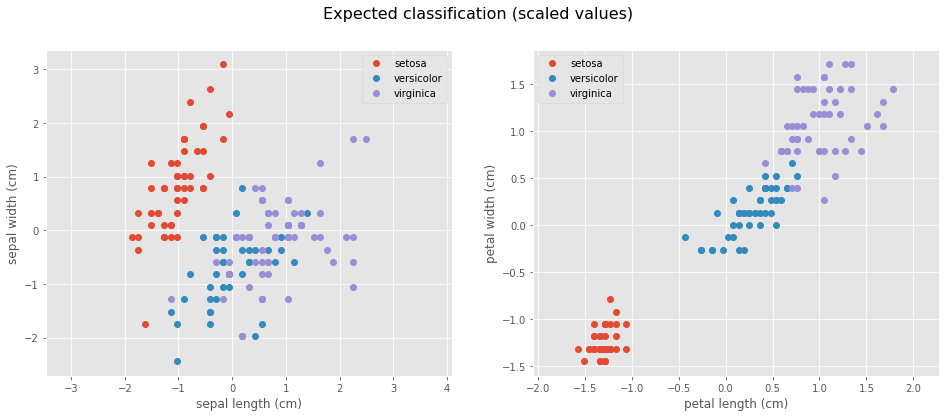

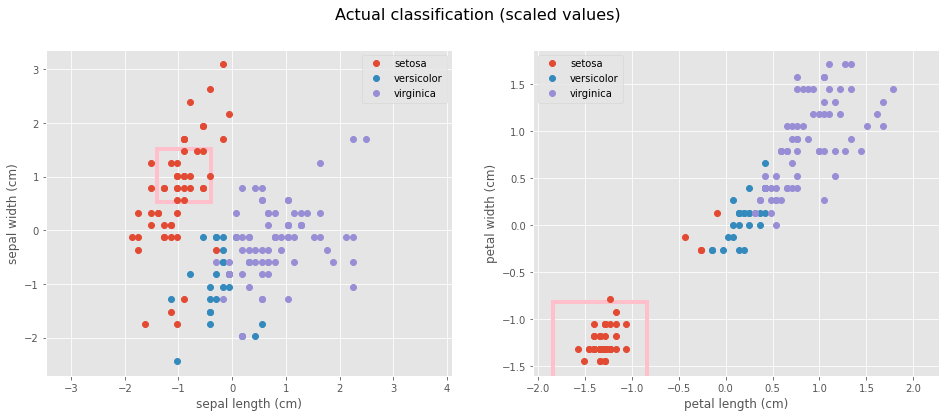

In [24]:
show_plots(X_scaled, y, title = 'Expected classification (scaled values)')
show_plots(X_scaled, predict(X_scaled, model), fixed_input_y, epsilon, title = 'Actual classification (scaled values)')

## Finding the largest epsilon for robustness with binary search
To find the largest epsilon for a fixed input value, we need to rewrite the verify function to return it's output as a boolean value. Therefore we use the solve() function and negate the verification condition.

Then we can simply use binary search and verify the robustness for an epsilon and then double the value of epsilon until an epsilon with a an unfulfilled robustness condition is found.

In [28]:
def verify_return(fixed_input_y, fixed_input_y_class, epsilon, weights, biases):
  input_size = fixed_input_y.shape[0]
  x = RealVector("x", input_size)

  # pre-condition
  # basically L_infinity-distance in boolean speak
  and_parts = []
  for i, x_vi in enumerate(x):
    and_parts.append(And((x_vi - fixed_input_y[i]) <= epsilon, (fixed_input_y[i] - x_vi) <= epsilon))
  pre_cond = And(and_parts)

  # post-condition
  # x_vo = x_v'
  output = net(x, weights, biases)
  or_parts = []
  for i, x_vo in enumerate(output):
    or_parts.append(x_vo > output[fixed_input_y_class])
  post_cond = Or(or_parts)

  verification_cond = And(pre_cond, post_cond)
  
  s = Solver()
  s.add(verification_cond)
  if s.check() == unsat:
        s.reset()
        return True
  else:
        s.reset()
        return False

def BinSearchMaxEpsilon(fixed_input_y, fixed_input_y_class, epsilonStart, weights, biases):
  currentEps = epsilonStart
  while verify_return(fixed_input_y, fixed_input_y_class, currentEps, weights, biases):
    print("Proven for Epsilon =", currentEps," Doubling Epsilon.")
    currentEps *= 2
  return currentEps/2

start_time = time.time()
print(BinSearchMaxEpsilon(fixed_input_y, fixed_input_y_class, epsilon, weights, biases))
print(f"{((time.time() - start_time)/60):.2f} minutes")

Proven for Epsilon = 0.5  Doubling Epsilon.
Proven for Epsilon = 1.0  Doubling Epsilon.
2.0
16.56 minutes


## Appendix

### Verify with each neuron encoded seperately

In [29]:
def ReluSingleNeuron(x):
  return If(x >= 0, x, RealVal(0))

def verify_each_neuron(fixed_input_y, fixed_input_y_class, epsilon, weights, biases):
  # Unpack weights of the trained model
  input_size = fixed_input_y.shape[0]
  neurons = []
  x = RealVector("x", input_size)
  output  = [RealVector(f"x{i}", weight.shape[0]) for i, weight in enumerate(weights)]

  # pre-condition
  # basically L_infinity-distance in boolean speak
  and_parts = []
  for i, x_vi in enumerate(x):
    and_parts.append(And((x_vi - fixed_input_y[i]) <= epsilon, (fixed_input_y[i] - x_vi) <= epsilon))
  pre_cond = And(and_parts)
  #print(pre_cond)

  # assign
  and_parts = []
  # for each layer
  for layer_i, (layer_output, layer_weights, layer_biases) in enumerate(zip(output, weights, biases)):
    # for each neuron
    for neuron_output, neuron_weights, neuron_bias in zip(layer_output, layer_weights, layer_biases):
      if layer_i == 0:
        # neuron input is net input
        neuron_inputs = x
      else:
        # neuron input is output of previous layer
        neuron_inputs = output[layer_i - 1]
      and_parts.append(neuron_output == ReluSingleNeuron(neuron_weights @ neuron_inputs + neuron_bias))
  assign = And(and_parts)

  # post-condition
  # x_vo = x_v'
  and_parts = []
  for i, x_vo in enumerate(output[-1]):
    # l is the argmax of fixed_input_y
    and_parts.append(x_vo <= output[-1][fixed_input_y_class])
  post_cond = And(and_parts)

  # verification conditions
  verification_cond = Implies(And(pre_cond, assign), post_cond)

  # prove using Z3
  prove(verification_cond)

In [30]:
start_time = time.time()
verify_each_neuron(fixed_input_y, fixed_input_y_class, epsilon, weights, biases)
print(f"{((time.time() - start_time)/60):.2f} minutes")

failed to prove


Z3Exception: ignored

### Another approach: Create Solver to find Adversarial Examples

The absolute value is defined as a helper function to aid in calculating the distance between 2 vectors when using z3.

In [31]:
def Abs(x):
    ret = If(x <= 0, -x, x)
    return ret

In the next section we search the adversarial example to a sample of the dataset. Therefore a sample runs through the trained model to predict an outcome.
The beforehand written function ```net(x)``` gets a manipulated input of the sample. A epsilon is added to every value of the input of the function.
To generate a vector epsilon which will constitute our manipulation of the input data with z3 the solver has to be defined first and then the constraints of our vectors as well as the inputs and outputs are added to the solver. The solver then has to check the satisfiability of the given constraints and a model is returned and printed if a vector epsilon which has a taxicab norm smaller than the constant e and changes the category with the highest probability exists.

In [74]:
def find_adversarial_example(num, s):
   # predict outcome of inputs with networkcuda:0!
    sample = Variable(torch.from_numpy(X_test[num])).float()
    y1 =  torch.argmax(model(sample.to(torch.device('cuda:0')))).tolist()
    print(y1)
    if (y1 == y_test[num]):
      print("The ML model predicted the correct flower.")
    else:
      print("The ML model predicted the wrong flower, for a correct example rerun the script.")

    epsilon = RealVector('epsilon', 4)
    # new sample with a little difference e (adversarial example)
    new_X = [x + e for (x, e) in zip(sample.detach().numpy(), epsilon)]
    y2_pred = net(new_X)

    e = 1
    s.add(Sum([Abs(a) for a in epsilon]) < e)
    # does work :
    # s.add(torch.argmax(y1).cpu().detach().numpy() != y2_pred)
    s.add(Or(y2_pred[0] > y2_pred[y1], y2_pred[1] > y2_pred[y1], y2_pred[2] > y2_pred[y1]))
    res = s.check()
    print(res)
    if res == sat:
        m = s.model()
        print(m)

In [75]:
for i in range(len(X_test)):
  s = Solver()
  find_adversarial_example(i, s)

0
The ML model predicted the correct flower.


TypeError: ignored